# Preparing nested simulations  

Running a nested ROMS simulation involves setting up a parent grid (red outline) and a child grid (green outline), as illustrated in the figure below.

<img src="images/nesting.png" alt="A nested simulation" width="500"/>

Proper preparation of a nested simulation can significantly save computation time and ensure smooth integration between the parent and child simulations. The necessary steps are as follows:


**Steps Before Running the Parent Simulation**:

1. **Map Child Grid Boundaries**:  
   The boundaries of the child grid must be mapped onto the parent grid's indices and saved in a NetCDF file. This file instructs ROMS to output the parent simulation state at the child grid boundaries at a specified frequency.  

**Steps Before Running the Child Simulation**:

2. **Adjust Child Grid Topography and Mask**:  
   The topography and mask of the child grid need to be adjusted such that they align with the parent grid at the child boundaries.  
3. **Prepare Boundary Forcing**:  
   Boundary forcing for the child simulation is generated from the parent simulation's state, which was output as a result of the preparation in Step 1.
4. **Regrid Initial Conditions**:  
   Initial conditions for the child simulation are regridded from the parent simulation results.  

This notebook guides you through these four steps.

## The `ChildGrid` object

Steps 1 and 2 are performed by the `ChildGrid` object. 

In [1]:
from roms_tools import Grid, ChildGrid

First, we create a parent grid using the `Grid` class, as usual.

In [2]:
parent_grid = Grid(
    nx=200,
    ny=200,
    size_x=2500,
    size_y=3000,
    center_lon=-30,
    center_lat=57,
    rot=-20,
    topography_source={
        "name": "SRTM15",
        "path": "/global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc",
    },
)

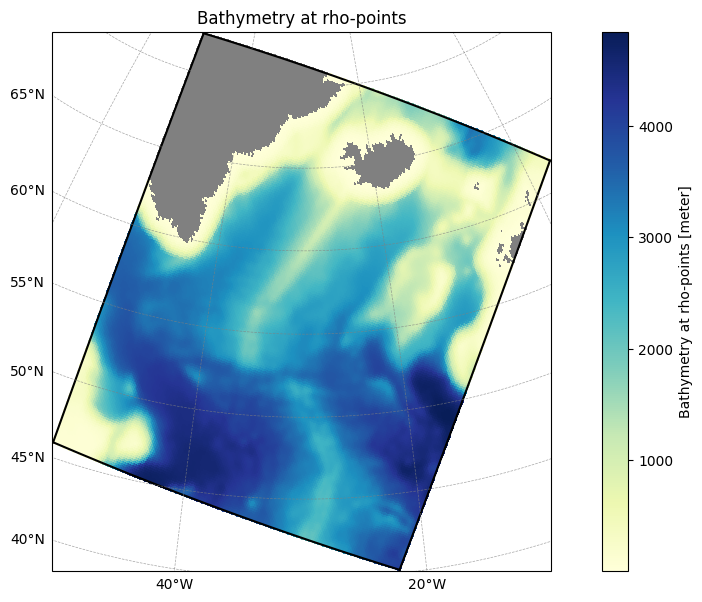

In [3]:
parent_grid.plot()

Next, we define the child grid using the following grid parameters.

In [4]:
child_grid_parameters = {
    "nx": 500,
    "ny": 500,
    "size_x": 400,
    "size_y": 400,
    "center_lon": -25,
    "center_lat": 65.5,
    "rot": 10,
    "topography_source": {
        "name": "SRTM15",
        "path": "/global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc",
    },
}

In addition to the standard grid parameters, the `ChildGrid` class requires a few additional parameters:

* `parent_grid`: The parent grid object, providing the reference for the child grid's topography and mask.
* `boundaries`: Specifies which of the child grid’s boundaries are open (`south`, `east`, `north`, `west`). Defaults to all `True`. This affects two aspects:
  * The specified boundaries are adjusted to match the parent grid’s topography and mask.
  * The specified boundaries are mapped onto parent grid indices.
* `metadata`: Contains configuration details related to boundary mapping and nesting behavior, including:
  * `"prefix"`: The prefix used for child grid variables in boundary mappings.
  * `"period"`: The temporal resolution (in seconds) for boundary outputs. Defaults to 3600 (hourly).

In [5]:
child_grid = ChildGrid(
    **child_grid_parameters,
    parent_grid=parent_grid,
    boundaries={
        "south": True,
        "east": True,
        "north": True,
        "west": True,
    },  # this is the default
    metadata={"prefix": "child", "period": 3600.0}  # this is the default
)

Similar to the `Grid` object, the `ChildGrid` has a `.ds` attribute, which contains an xarray Dataset that holds all the grid variables.

In [6]:
child_grid.ds

<xarray.Dataset> Size: 32MB
Dimensions:       (eta_rho: 502, xi_rho: 502, xi_u: 501, eta_v: 501,
                   eta_coarse: 252, xi_coarse: 252, s_rho: 100, s_w: 101)
Coordinates:
    lat_rho       (eta_rho, xi_rho) float64 2MB 63.37 63.38 ... 67.54 67.54
    lon_rho       (eta_rho, xi_rho) float64 2MB 331.7 331.8 ... 338.8 338.8
    lat_u         (eta_rho, xi_u) float64 2MB 63.38 63.38 63.38 ... 67.54 67.54
    lon_u         (eta_rho, xi_u) float64 2MB 331.7 331.8 331.8 ... 338.8 338.8
    lat_v         (eta_v, xi_rho) float64 2MB 63.38 63.38 63.38 ... 67.54 67.54
    lon_v         (eta_v, xi_rho) float64 2MB 331.7 331.8 331.8 ... 338.8 338.8
    lat_coarse    (eta_coarse, xi_coarse) float64 508kB 63.37 63.37 ... 67.55
    lon_coarse    (eta_coarse, xi_coarse) float64 508kB 331.7 331.8 ... 338.8
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v, eta_coarse,
                                xi_coarse, s_rho, s_w
Data variables: (12/17)
    angle         (eta_rho, xi_rho) float64 2MB 0.2261 0.2261 ... 0.114 0.114
    f             (eta_rho, xi_rho) float64 2MB 0.00013 0.00013 ... 0.0001344
    pm            (eta_rho, xi_rho) float64 2MB 0.001251 0.001251 ... 0.001251
    pn            (eta_rho, xi_rho) float64 2MB 0.001251 0.001251 ... 0.001251
    spherical     |S1 1B b'T'
    mask_rho      (eta_rho, xi_rho) int64 2MB 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    ...            ...
    sigma_r       (s_rho) float32 400B -0.995 -0.985 -0.975 ... -0.015 -0.005
    Cs_r          (s_rho) float32 400B -0.992 -0.9753 ... -8.89e-05 -9.874e-06
    sigma_w       (s_w) float32 404B -1.0 -0.99 -0.98 -0.97 ... -0.02 -0.01 0.0
    Cs_w          (s_w) float32 404B -1.0 -0.9837 -0.9667 ... -3.95e-05 0.0
    angle_u       (eta_rho, xi_u) float64 2MB 0.2261 0.226 ... 0.1142 0.114
    angle_v       (eta_v, xi_rho) float64 2MB 0.2262 0.2262 ... 0.114 0.114
Attributes: (12/14)
    title:                   ROMS grid created by ROMS-Tools
    roms_tools_version:      3.1.2.dev23+gc2b82bc5c
    size_x:                  400
    size_y:                  400
    center_lon:              -25
    center_lat:              65.5
    ...                      ...
    topography_source_name:  SRTM15
    topography_source_path:  /global/cfs/projectdirs/m4746/Datasets/SRTM15/SR...
    hmin:                    5.0
    theta_s:                 5.0
    theta_b:                 2.0
    hc:                      300.0

We can plot the bathymetry of the child grid using the standard `.plot` method.

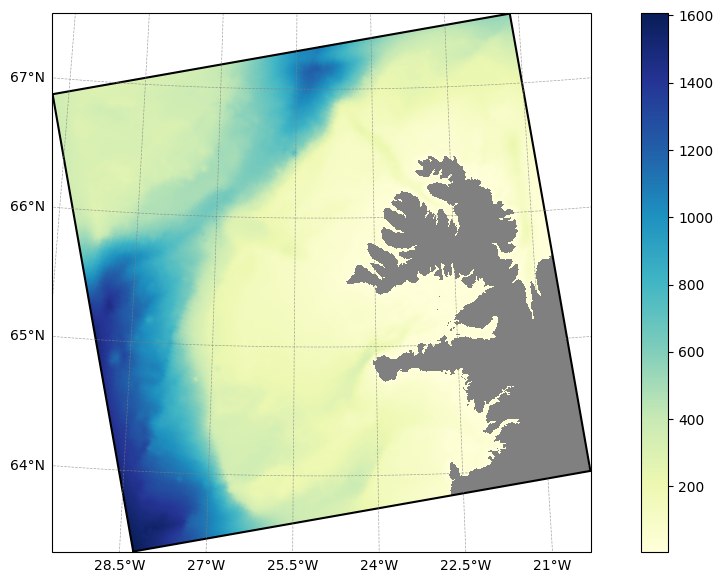

In [7]:
child_grid.plot()

Next, we can plot the parent and child grids together with the `.plot_nesting` method to visualize their relative positions.

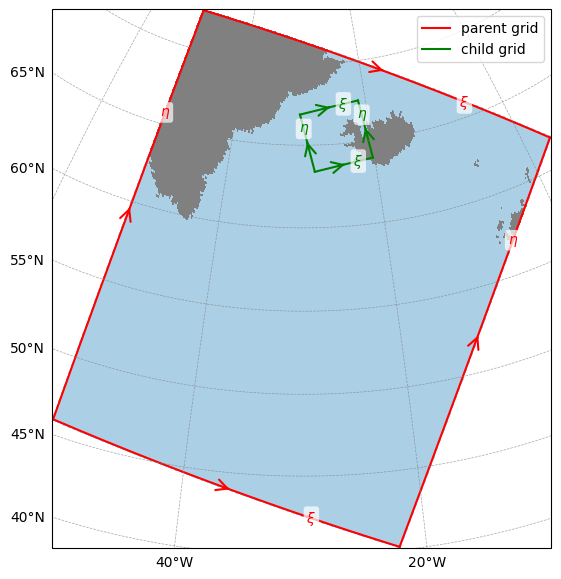

In [8]:
child_grid.plot_nesting(with_dim_names=True)

### Adjusted topography and mask

Let's examine the outcome of Step 2, where the child grid's topography (or bathymetry) and mask have been adjusted to align with the parent grid.  Above, we plotted the bathymetry of our child grid. For comparison, here is another grid with the same parameters as our child grid, but created independently—without a parent grid.

In [9]:
child_grid_without_parent = Grid(**child_grid_parameters)

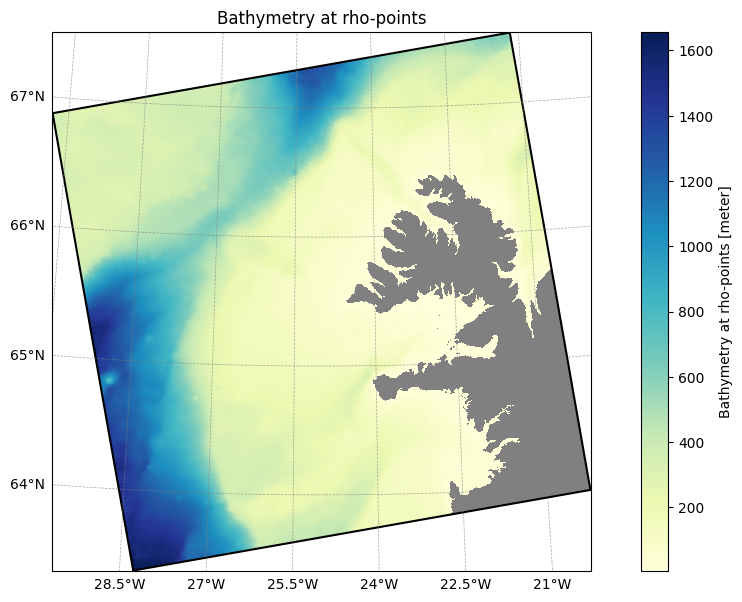

In [10]:
child_grid_without_parent.plot()

We can visualize the difference between the two bathymetries of our child grid (with and without a parent grid) by plotting their difference.

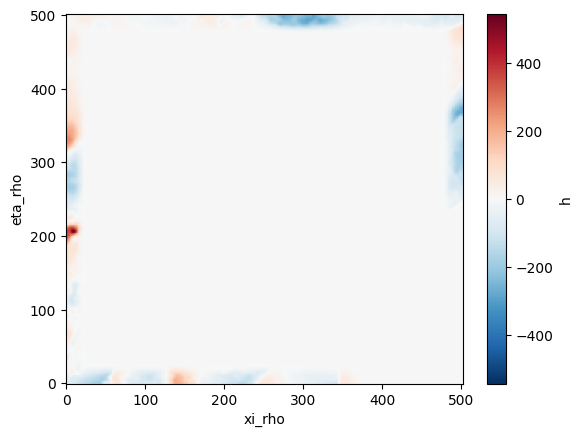

In [11]:
(child_grid.ds.h - child_grid_without_parent.ds.h).plot()

The topography modifications are concentrated near the boundaries. Everywhere else, the child topography remains unchanged.

The mask of the child grid **with parent** has also been adjusted along the boundaries (in comparison to the child grid **without** a parent) to better align with the mask of the parent grid.

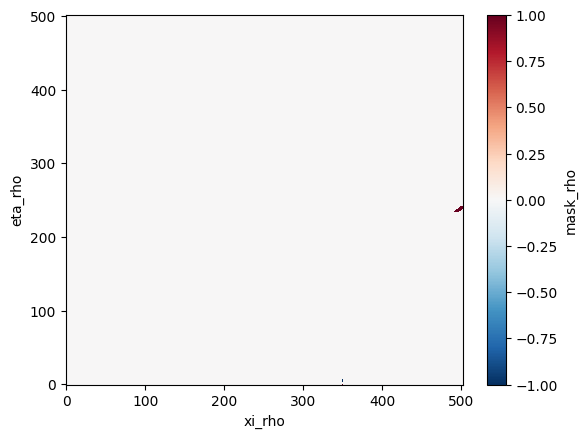

In [12]:
(child_grid.ds.mask_rho - child_grid_without_parent.ds.mask_rho).plot()

### Child grid boundaries mapped onto parent grid indices

The boundaries of the child grid have been mapped onto the parent grid's indices (Step 1) and are now stored in an `xarray.Dataset` accessible via the `.ds_nesting` property.

In [13]:
child_grid.ds_nesting

<xarray.Dataset> Size: 128kB
Dimensions:        (two: 2, child_xi_rho: 502, three: 3, child_xi_u: 501,
                    child_eta_rho: 502, child_eta_v: 501)
Dimensions without coordinates: two, child_xi_rho, three, child_xi_u,
                                child_eta_rho, child_eta_v
Data variables:
    child_south_r  (two, child_xi_rho) float64 8kB 87.12 87.18 ... 160.5 160.5
    child_south_u  (three, child_xi_u) float64 12kB 87.15 87.2 ... 0.09919
    child_south_v  (three, child_xi_rho) float64 12kB 87.11 87.16 ... 0.0992
    child_east_r   (two, child_eta_rho) float64 8kB 105.5 105.5 ... 183.6 183.6
    child_east_u   (three, child_eta_rho) float64 12kB 105.4 105.4 ... 0.114
    child_east_v   (three, child_eta_v) float64 12kB 105.4 105.4 ... 0.114 0.114
    child_north_r  (two, child_xi_rho) float64 8kB 69.02 69.07 ... 183.6 183.6
    child_north_u  (three, child_xi_u) float64 12kB 69.05 69.1 ... 0.1142 0.114
    child_north_v  (three, child_xi_rho) float64 12kB 69.04 69.09 ... 0.114
    child_west_r   (two, child_eta_rho) float64 8kB 87.12 87.09 ... 168.5 168.5
    child_west_u   (three, child_eta_rho) float64 12kB 87.15 87.11 ... 0.2587
    child_west_v   (three, child_eta_v) float64 12kB 87.11 87.07 ... 0.2587

You can see that the `metadata` we provided earlier has been incorporated into this dataset:
* The prefix `"child"` has been prepended to all data variable names.
* The period `3600.0` is now included as an attribute for every data variable.

To better understand the variables in `child_grid.ds_nesting`, let's create a plot.

In [14]:
import matplotlib.pyplot as plt

def plot_boundary_indices(child_grid, grid_location="rho"):
    fig, axs = plt.subplots(2, 2, figsize=(10, 7))

    title = (
        f"{grid_location}-points of child boundaries mapped onto parent grid indices"
    )

    if grid_location == "rho":
        grid_location = "r"
        dim = "two"
    else:
        dim = "three"

    for direction, ax in zip(["south", "east", "north", "west"], axs.flatten()):
        child_grid.ds_nesting[f"child_{direction}_{grid_location}"].isel({dim: 0}).plot(
            ax=ax, label="xi-index"
        )
        child_grid.ds_nesting[f"child_{direction}_{grid_location}"].isel({dim: 1}).plot(
            ax=ax, label="eta-index"
        )
        ax.set_title(f"{direction}ern child boundary")
        ax.set_ylabel("Absolute parent grid index")
        ax.legend()

    plt.tight_layout()
    fig.suptitle(title, y=1.05)

    return fig

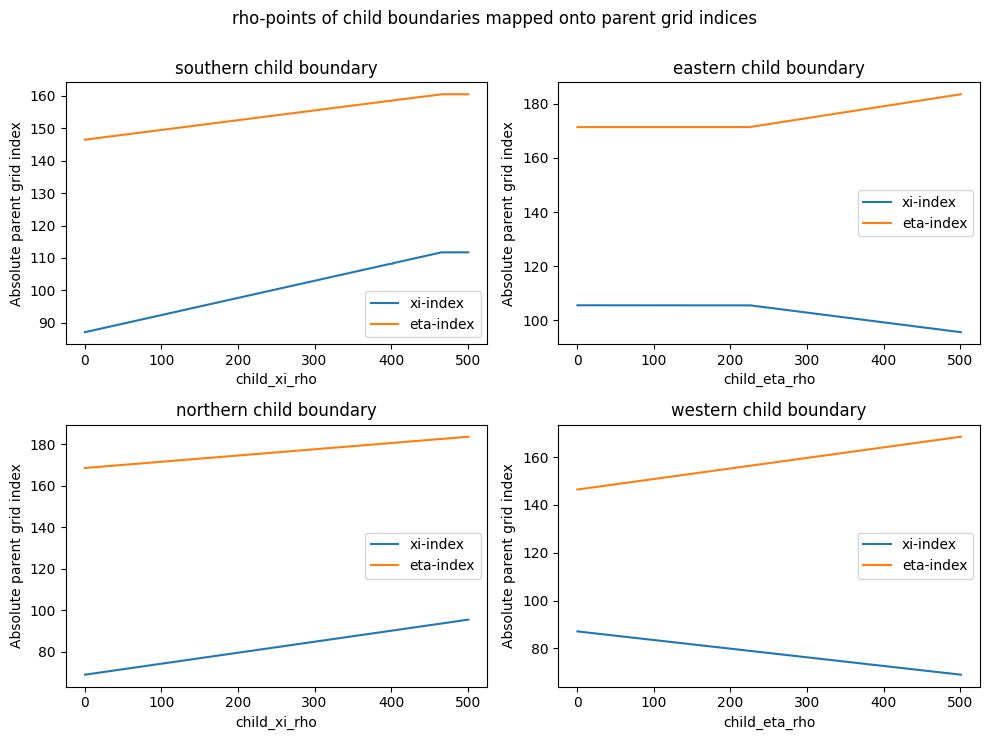

In [15]:
fig = plot_boundary_indices(child_grid)

Here are a few sanity checks when comparing the spatial figure (showing the red parent grid and green child grid) with the line plots we just created:

1. The child domain is positioned in the northern part of the parent domain relative to the `eta` direction but is centrally located relative to the `xi` direction (as shown in the spatial figure). This matches the `eta-index` (orange lines), which ranges approximately from [145, 180] (out of the total `eta` range of [0, 200]), and the `xi-index`, which spans roughly [70, 110], (out of the total `xi` range of [0, 200]).

2. Along the western child boundary, moving from south to north causes the `eta` index to increase and the `xi` index to decrease (as seen in the spatial figure). This corresponds to the line plots in the fourth subplot, where the orange line increases monotonically and the blue line decreases monotonically.

3. The southern and eastern boundaries intersect with land (as indicated in the spatial figure). These are the boundaries where the line plots are not strictly monotonic. Whenever parent land is encountered, the indices are mapped to the nearest parent wet point, which explains the plateaus in the plots.

### Saving as NetCDF or YAML file

We can now save the two datasets that were created for the `ChildGrid` object as NetCDF files.

* The grid information itself (`.ds`) can be saved using the `.save` method.
* The boundary mapping information (`.ds_nesting`) can be saved using the `.save_nesting` method.

In [16]:
filepath = "/pscratch/sd/n/nloose/nesting/child_grid.nc"

In [17]:
child_grid.save(filepath=filepath)

2025-11-18 16:04:33 - INFO - Writing the following NetCDF files:
/pscratch/sd/n/nloose/nesting/child_grid.nc


[PosixPath('/pscratch/sd/n/nloose/nesting/child_grid.nc')]

In [18]:
filepath_nesting = "/pscratch/sd/n/nloose/nesting/nesting_info.nc"

In [19]:
child_grid.save_nesting(filepath=filepath_nesting)

2025-11-18 16:04:34 - INFO - Writing the following NetCDF files:
/pscratch/sd/n/nloose/nesting/nesting_info.nc


[PosixPath('/pscratch/sd/n/nloose/nesting/nesting_info.nc')]

We can also export the `ChildGrid` parameters to a YAML file.

In [20]:
yaml_filepath = "/pscratch/sd/n/nloose/nesting/child_grid.yaml"

In [21]:
child_grid.to_yaml(yaml_filepath)

This is the YAML file that was created.

In [22]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 3.1.2.dev23+gc2b82bc5c
---
ParentGrid:
  nx: 200
  ny: 200
  size_x: 2500
  size_y: 3000
  center_lon: -30
  center_lat: 57
  rot: -20
  N: 100
  theta_s: 5.0
  theta_b: 2.0
  hc: 300.0
  topography_source:
    name: SRTM15
    path: /global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc
  hmin: 5.0
ChildGrid:
  nx: 500
  ny: 500
  size_x: 400
  size_y: 400
  center_lon: -25
  center_lat: 65.5
  rot: 10
  N: 100
  theta_s: 5.0
  theta_b: 2.0
  hc: 300.0
  topography_source:
    name: SRTM15
    path: /global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc
  hmin: 5.0
  boundaries:
    south: true
    east: true
    north: true
    west: true
  metadata:
    prefix: child
    period: 3600.0



### Creating nesting information from an existing YAML file

In [23]:
the_same_child_grid = ChildGrid.from_yaml(yaml_filepath)

## Boundary Forcing

Coming soon!

## Initial Conditions

Coming soon!